In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels. api as sm
import statsmodels.formula.api as smf
import sys, os
import seaborn as sns
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [2]:
import ast
import re
import time
import json

In [3]:
CURRENTDIR = os.path.dirname(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))))
results = pd.read_excel(os.path.join(CURRENTDIR,"data/extracted_data.xlsx"))

# Linguistic Data

In [4]:
results=results.drop(results[results.locutor == 1].index)
results=results.reset_index(drop=True)
results['Agent']='H'
results['Agent'][results.conv==2]='R'
results.rename({'conv_id_unif':'Trial', 'trial':'Trial'},axis='columns', inplace='True') # either one or the other

In [5]:
results.head()

,locutor,block,conv,it,Trial,tier,extract_sentiment,extract_subjectivity,lexical_richness,linguistic_complexity,mean_ipu_lgth,ratio_silence_lgth,sum_ipu_lgth,ratio_discourse,ratio_feedback,ratio_filled_pause,extract_text,Agent
0,2,1,1,1,0,conversant,0.000000,0.000000,0.189655,0.362069,1.390071,0.693713,18.070919,0.017241,0.120690,0.120690,oui oui on dirait par contre elle a été découp...,H
1,2,1,1,1,0,participant,0.000000,0.000000,0.277778,0.203704,1.771997,0.729695,15.947977,0.037037,0.092593,0.000000,c'est une aubergine oui en forme de visage gen...,H
2,2,1,1,3,1,conversant,0.333333,0.666667,0.070175,0.421053,1.294609,0.736690,15.535303,0.017544,0.105263,0.087719,ouais on dirait ouais y a un masque mh mh ça f...,H
3,2,1,1,3,1,participant,0.333333,0.666667,0.095238,0.380952,1.644853,0.693333,18.093379,0.031746,0.047619,0.031746,c'est un citron qui est toujours en forme de s...,H
4,2,1,1,5,2,conversant,0.277778,0.611111,0.119403,0.388060,1.275950,0.675606,19.139248,0.044776,0.119403,0.164179,ouais ouais mh avec les yeux découpés tout ça ...,H


In [6]:
res = results[['locutor', 'Trial', 'Agent','tier', 'lexical_richness', 'sum_ipu_lgth']]
print(res.shape)
res.head()

(1152, 6)


,locutor,Trial,Agent,tier,lexical_richness,sum_ipu_lgth
0,2,0,H,conversant,0.189655,18.070919
1,2,0,H,participant,0.277778,15.947977
2,2,1,H,conversant,0.070175,15.535303
3,2,1,H,participant,0.095238,18.093379
4,2,2,H,conversant,0.119403,19.139248


# Read neuro data

In [33]:
datan = pd.read_csv('data_neuro/Full.txt', sep='\t', header=None, names=["area", "locutor", "session", "image", "bold", "Agent", "Trial"], skipfooter=1)

In [43]:
datan['area'] = datan.area.apply(lambda x: 'area_{}'.format(x))

In [44]:
datan.tail(5)

,area,locutor,session,image,bold,Agent,Trial,area_name
148195,area_247,25,4,2,-0.2196,R,9,area_247
148196,area_247,25,4,3,-0.4430,H,10,area_247
148197,area_247,25,4,4,0.1330,R,10,area_247
148198,area_247,25,4,5,-0.4128,H,11,area_247
148199,area_247,25,4,6,-0.6881,R,11,area_247


In [45]:
datan.dtypes

area          object
locutor        int64
session        int64
image          int64
bold         float64
Agent         object
Trial          int64
area_name     object
dtype: object

In [37]:
datan.Trial = datan.Trial - 1

In [38]:
datan.Agent = datan.Agent.apply(lambda x: x.strip())

In [46]:
pivot_datan = pd.pivot_table(datan, columns='area', values='bold', index=['locutor', 'session', 'Agent', 'Trial', 'image'], aggfunc=np.sum).reset_index()
#pivot_datan = pivot_datan[[c for c in pivot_datan.columns if c != 'area']]
print(pivot_datan.shape)
pivot_datan.head()

(600, 252)


area,locutor,session,Agent,Trial,image,area_1,area_10,area_100,area_101,area_102,...,area_90,area_91,area_92,area_93,area_94,area_95,area_96,area_97,area_98,area_99
0,1,1,H,0,1,0.2090,-0.1090,-0.3355,-1.2060,-0.6798,...,-0.4143,-0.1367,1.3513,0.2285,-0.0071,-1.0003,-0.7036,-0.9167,-1.4843,-0.1470
1,1,1,H,1,3,0.0180,-0.0335,-0.2577,-0.1222,-0.7517,...,0.1244,-0.2431,-0.1556,-0.2474,-0.1675,-0.5092,-0.3752,-0.7614,-1.0452,-0.0131
2,1,1,H,2,5,-0.1453,-0.4794,-0.5420,-0.2818,-1.2390,...,-0.7084,-0.1378,-0.8540,-0.3118,-0.2643,-0.6382,-0.9054,-0.7796,-1.0091,-0.2740
3,1,1,R,0,2,0.0166,-0.1913,-0.4633,-0.5788,-0.1616,...,-0.1466,0.5799,1.3464,0.1944,0.3474,-0.3708,-0.2235,-0.1736,-0.7246,-0.0639
4,1,1,R,1,4,0.0739,-0.1027,-0.1775,0.2257,-0.1629,...,0.0022,0.6647,0.7734,0.1290,0.0777,-0.0462,-0.2060,-0.3393,-0.6756,-0.0232


In [47]:
pivot_datan.dtypes

area
locutor      int64
session      int64
Agent       object
Trial        int64
image        int64
            ...   
area_95    float64
area_96    float64
area_97    float64
area_98    float64
area_99    float64
Length: 252, dtype: object

In [48]:
pivot_datan.Agent.unique()

array(['H', 'R'], dtype=object)

# Stats

## Pretests

In [16]:
formula_1 = "bold ~ data_part * Agent + Trial + (1 + Trial | locutor)"
formula_2 = "bold ~ data_conv * Agent + Trial + (1 + Trial | locutor)"
formula_weird = "bold ~ data_diff * Agent + Trial + (1 + Trial | locutor)"

In [10]:
participant = results[results.tier == 'participant'][['locutor', 'Trial', 'lexical_richness', 'Agent']]
conversant = results[results.tier == 'conversant'][['locutor', 'Trial', 'lexical_richness', 'Agent']]

merres = pd.merge(participant, conversant, on=['locutor', 'Trial', 'Agent'], suffixes=('_participant', '_conversant'), validate="one_to_one")
print(merres.shape)
merres.head()

(576, 5)


,locutor,Trial,lexical_richness_participant,Agent,lexical_richness_conversant
0,2,0,0.277778,H,0.189655
1,2,1,0.095238,H,0.070175
2,2,2,0.196078,H,0.119403
3,2,0,0.027027,R,0.068966
4,2,1,0.205128,R,0.104167


## Quick tests with [prediction models](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py)

In [11]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

classifiers = {'NB':GaussianNB(), 'QDA':QuadraticDiscriminantAnalysis()}

In [22]:
X = merres[['lexical_richness_conversant', 'lexical_richness_participant']].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, pd.get_dummies(merres['Agent'])['R'])

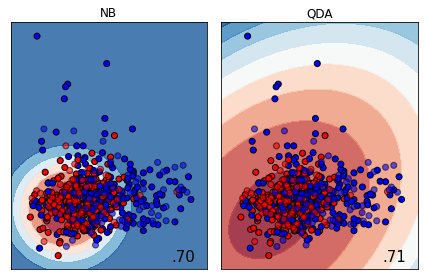

In [27]:
from matplotlib.colors import ListedColormap

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
h = .02
x_min, x_max = X[:, 0].min() - .05, X[:, 0].max() + .05
y_min, y_max = X[:, 1].min() - .05, X[:, 1].max() + .05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

for i, (k, clf) in enumerate(classifiers.items()):
    ax = plt.subplot(1, len(classifiers), i+1)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(xx.max() - .03, yy.min() + .03, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')
    ax.set_title(k)

plt.tight_layout()
plt.show()

## Setting up procedure

1. Merge merres
2. Rename columns
3. Merge neuro
4. Create column data_diff
5. Check for 1 model
6. Loop over `sum_ipu`, `lexical_complexity` - two chosen variables

In [18]:
md = smf.mixedlm("mean_ipu_lgth_participant ~ mean_ipu_lgth_conversant * Agent + Trial", merres, groups=merres["locutor"], re_formula="1 + Trial")
mdf = md.fit()
print(mdf.summary())

Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   mean_ipu_lgth_participant
No. Observations:    576       Method:               REML                     
No. Groups:          24        Scale:                0.1082                   
Min. group size:     24        Log-Likelihood:       -221.7579                
Max. group size:     24        Converged:            Yes                      
Mean group size:     24.0                                                     
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                            1.469    0.092 15.909 0.000  1.288  1.650
Agent[T.R]                          -0.290    0.115 -2.522 0.012 -0.515 -0.065
mean_ipu_lgth_conversant            -0.066    0.045 -1.479 0.139 -0.154  0.022
mean_ipu_lgth_

In [19]:
mdf.pvalues[['Intercept', 'Agent[T.R]', 'mean_ipu_lgth_conversant', 'mean_ipu_lgth_conversant:Agent[T.R]']]

Intercept                              5.456810e-57
Agent[T.R]                             1.165564e-02
mean_ipu_lgth_conversant               1.390659e-01
mean_ipu_lgth_conversant:Agent[T.R]    5.523615e-01
dtype: float64

In [20]:
#mdf.conf_int
mdf.fe_params

Intercept                              1.469319
Agent[T.R]                            -0.289542
mean_ipu_lgth_conversant              -0.066334
mean_ipu_lgth_conversant:Agent[T.R]    0.048772
Trial                                  0.030562
dtype: float64

In [22]:
mdf.tvalues

Intercept                              15.909360
Agent[T.R]                             -2.522402
mean_ipu_lgth_conversant               -1.479278
mean_ipu_lgth_conversant:Agent[T.R]     0.594225
Trial                                   7.157490
Group Var                               2.497209
Group x Trial Cov                       1.407396
Trial Var                               0.382257
dtype: float64

## Executing

In [49]:
areas = datan.area.unique()
areas[-10:]

array(['area_238', 'area_239', 'area_240', 'area_241', 'area_242',
       'area_243', 'area_244', 'area_245', 'area_246', 'area_247'],
      dtype=object)

In [26]:
int_cols = ['sum_ipu_lgth', 'lexical_richness']
main_cols = ['locutor', 'Trial', 'Agent']

In [47]:
participant = results[results.tier == 'participant'][main_cols+int_cols]
conversant = results[results.tier == 'conversant'][main_cols+int_cols]


In [48]:
merres = pd.merge(participant, conversant, on=main_cols, suffixes=('_part', '_conv'), validate="one_to_one")
print(merres.shape)
merres.head()

(576, 7)


,locutor,Trial,Agent,sum_ipu_lgth_part,lexical_richness_part,sum_ipu_lgth_conv,lexical_richness_conv
0,2,0,H,15.947977,0.277778,18.070919,0.189655
1,2,1,H,18.093379,0.095238,15.535303,0.070175
2,2,2,H,11.008483,0.196078,19.139248,0.119403
3,2,0,R,8.772955,0.027027,7.629693,0.068966
4,2,1,R,11.521834,0.205128,14.340964,0.104167


In [92]:
merneuro = pd.merge(merres, pivot_datan, on=main_cols, suffixes=('_ling', '_bold'), validate="one_to_one")

In [99]:
print(merneuro.shape)
merneuro.head()

(576, 258)


,locutor,Trial,Agent,sum_ipu_lgth_part,lexical_richness_part,sum_ipu_lgth_conv,lexical_richness_conv,session,image,area_1,...,area_92,area_93,area_94,area_95,area_96,area_97,area_98,area_99,sum_ipu_lgth_diff,lexical_richness_diff
0,2,0,H,15.947977,0.277778,18.070919,0.189655,1,1,-0.1116,...,-1.4109,0.0661,0.0674,-0.3111,0.5074,-0.5281,-0.5318,-0.4355,-2.122942,0.088123
1,2,1,H,18.093379,0.095238,15.535303,0.070175,1,3,0.0257,...,-0.6778,-0.5158,-0.3342,0.3477,1.3214,-0.5048,-0.5134,-0.1995,2.558076,0.025063
2,2,2,H,11.008483,0.196078,19.139248,0.119403,1,5,0.1619,...,-0.5590,-0.7275,-0.4895,-0.6774,1.0673,-0.1690,-0.2506,0.0814,-8.130766,0.076675
3,2,0,R,8.772955,0.027027,7.629693,0.068966,1,2,-0.0307,...,0.0546,-0.4056,-0.1130,0.4683,0.0310,-0.3289,-0.3144,0.1461,1.143261,-0.041938
4,2,1,R,11.521834,0.205128,14.340964,0.104167,1,4,-0.0351,...,-0.7013,-0.4642,-0.0276,-1.0314,-0.8013,-0.5495,-0.5178,-0.1904,-2.819130,0.100962


In [95]:
for c in int_cols:
    merneuro[c+'_diff'] = merneuro[c+'_part'] - merneuro[c+'_conv']
print(merneuro.shape)

(576, 258)


In [108]:
pvalues = {}
estimates = {}

In [109]:
start_time = time.time()
re_f = "1 + Trial"
for c in int_cols:
    print(c)
    p_c_dic = {}
    e_c_dic = {}
    for formula_part in ['_part', '_conv', '_diff']:
        print('\t', formula_part)
        p_f_dic = []
        e_f_dic = []
        for ar in areas:
            formula_1 = "{} ~ {} * Agent + Trial".format(ar, c+formula_part)
            print(formula_1)
            md = smf.mixedlm(formula_1, merneuro, groups=merneuro["locutor"], re_formula=re_f)
            mdf = md.fit()
            p_f_dic.append(mdf.pvalues[['Intercept', 'Agent[T.R]', c+formula_part, c+formula_part+':Agent[T.R]']])
            e_f_dic.append(mdf.fe_params)
        p_c_dic[formula_part] = pd.DataFrame(p_f_dic)
        e_c_dic[formula_part] = pd.DataFrame(e_f_dic)
    pvalues[c] = p_c_dic
    estimates[c] = e_c_dic


g: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
area_182 ~ lexical_richness_diff * Agent + Trial
/Users/neako/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
area_183 ~ lexical_richness_diff * Agent + Trial
/Users/neako/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
area_184 ~ lexical_richness_diff * Agent + Trial
/Users/neako/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
area_185 ~ lexical_richness_diff * Agent + Trial
/Users/neako/anaconda3/lib/python3.7/site-packages/

In [139]:
with open('pvalues.txt', 'w') as json_file:
  json.dump({c:{f:df.values.tolist() for f, df in v.items()} for c,v in pvalues.items()}, json_file)
with open('estimates.txt', 'w') as json_file:
  json.dump({c:{f:df.values.tolist() for f, df in v.items()} for c,v in estimates.items()}, json_file)

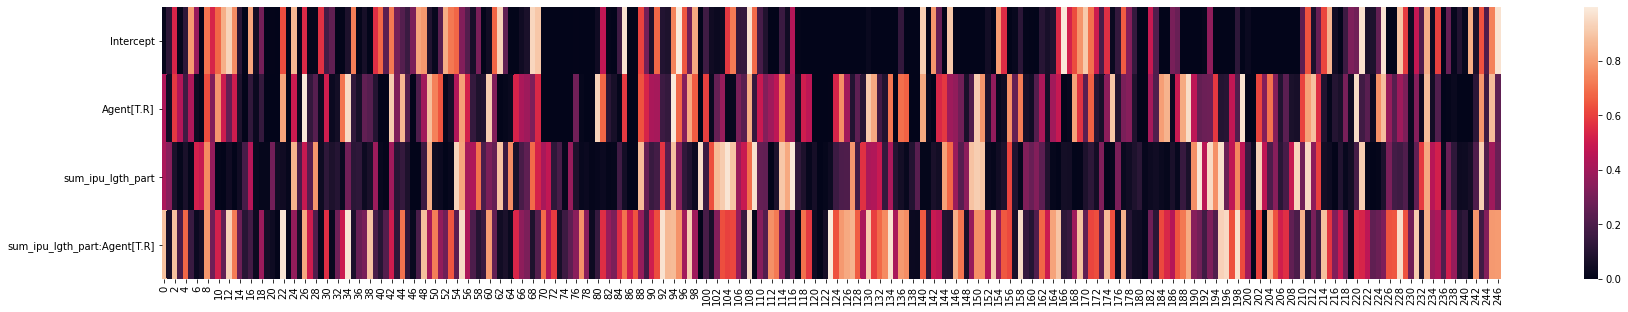

In [115]:
plt.subplots(figsize=(30, 5))
sns.heatmap(pvalues['sum_ipu_lgth']['_part'].T)

In [117]:
def change_color(p, ticks=np.array([0.001, 0.01, 0.05, 1])):
    return min(ticks[ticks > p])

In [144]:
ex_pval_change = pvalues['sum_ipu_lgth']['_part'].applymap(lambda x : change_color(x))

In [147]:
estimates['sum_ipu_lgth']['_part'][(ex_pval_change['sum_ipu_lgth_part:Agent[T.R]'] < 1)]

,Intercept,Agent[T.R],sum_ipu_lgth_part,sum_ipu_lgth_part:Agent[T.R],Trial
6,-0.050724,0.103418,0.001532,-0.005302,-0.003088
17,-0.189758,0.192775,-0.009687,-0.009429,0.007519
20,-0.231934,0.271290,-0.003531,-0.007389,0.003960
21,-0.298070,0.306348,-0.006938,-0.010790,0.002827
23,-0.318008,0.291109,-0.010319,-0.011311,0.007719
29,-0.061130,0.201776,-0.009795,-0.011461,0.011041
31,-0.129456,0.216019,-0.008603,-0.011659,0.004838
46,0.315521,-0.784719,-0.040144,0.032376,0.002797
62,-0.007274,0.228979,-0.000475,-0.007098,0.000242
64,-0.377588,0.151453,-0.001018,-0.007625,0.004237


In [ ]:
pvalues_aes = {c:{f: for f, df in v.items()} for c,v in pvalues.items()}

In [149]:
pvalues.keys()

dict_keys(['sum_ipu_lgth', 'lexical_richness'])

In [150]:
writer = pd.ExcelWriter('pvalues_neuro.xlsx')
for c in int_cols:
    for formula_part in ['_part', '_conv', '_diff']:
        df = pvalues[c][formula_part]
        df[df[c+formula_part+':Agent[T.R]'] <= 0.05].to_excel(writer, sheet_name=c+formula_part)
writer.save()
print('Saved successfully')

Saved successfully


If you need to have qt first in your PATH run:
```
  echo 'export PATH="/usr/local/opt/qt/bin:$PATH"' >> ~/.bash_profile
```

For compilers to find qt you may need to set:

```
  export LDFLAGS="-L/usr/local/opt/qt/lib"
  export CPPFLAGS="-I/usr/local/opt/qt/include"
```

For pkg-config to find qt you may need to set:
```
  export PKG_CONFIG_PATH="/usr/local/opt/qt/lib/pkgconfig"
```

https://github.com/ageitgey/face_recognition/issues/1041 ... en fait installer `opencv` corrige --' 

# Image Generation

In [157]:
import nibabel as nib
from visbrain.objects import (BrainObj, SceneObj, SourceObj, ConnectObj)

In [154]:
l_file = "../visbrain/parcellation/lh.BN_Atlas.annot"
r_file = "../visbrain/parcellation/rh.BN_Atlas.annot"

In [155]:
annot_l = nib.freesurfer.io.read_annot (l_file)
annot_r = nib.freesurfer.io.read_annot (r_file)

In [159]:
obj = BrainObj('inflated', hemisphere='right', translucent=False, _scale = 1.5)
annot_data = obj.get_parcellates(r_file)

BrainObj(name='inflated') created
    Annot file loaded (../visbrain/parcellation/rh.BN_Atlas.annot)


In [161]:
annot_data.Labels.unique()

array(['Unknown', 'A8m_L', 'A8m_R', 'A8dl_L', 'A8dl_R', 'A9l_L', 'A9l_R',
       'A6dl_L', 'A6dl_R', 'A6m_L', 'A6m_R', 'A9m_L', 'A9m_R', 'A10m_L',
       'A10m_R', 'A9/46d_L', 'A9/46d_R', 'IFJ_L', 'IFJ_R', 'A46_L',
       'A46_R', 'A9/46v_L', 'A9/46v_R', 'A8vl_L', 'A8vl_R', 'A6vl_L',
       'A6vl_R', 'A10l_L', 'A10l_R', 'A44d_L', 'A44d_R', 'IFS_L', 'IFS_R',
       'A45c_L', 'A45c_R', 'A45r_L', 'A45r_R', 'A44op_L', 'A44op_R',
       'A44v_L', 'A44v_R', 'A14m_L', 'A14m_R', 'A12/47o_L', 'A12/47o_R',
       'A11l_L', 'A11l_R', 'A11m_L', 'A11m_R', 'A13_L', 'A13_R',
       'A12/47l_L', 'A12/47l_R', 'A4hf_L', 'A4hf_R', 'A6cdl_L', 'A6cdl_R',
       'A4ul_L', 'A4ul_R', 'A4t_L', 'A4t_R', 'A4tl_L', 'A4tl_R',
       'A6cvl_L', 'A6cvl_R', 'A1/2/3ll_L', 'A1/2/3ll_R', 'A4ll_L',
       'A4ll_R', 'A38m_L', 'A38m_R', 'A41/42_L', 'A41/42_R',
       'TE1.0/TE1.2_L', 'TE1.0/TE1.2_R', 'A22c_L', 'A22c_R', 'A38l_L',
       'A38l_R', 'A22r_L', 'A22r_R', 'A21c_L', 'A21c_R', 'A21r_L',
       'A21r_R', 'A37dl_L',

In [163]:
for area in [175, 176,  42, 206, 100, 102, 108]:
    print(annot_data["Labels"][area])

A23d_L
A23d_R
A14m_R
iOccG_R
A20cl_R
A20cv_R
A37lv_R


In [165]:
annot_data.shape, len(annot_data.Labels.unique())

((211, 3), 211)

* *BrainnetomeAtlasViewer.zip* 
* README 
* BN_Atlas_freesurfer.zip 
* BN_Atlas_246_1mm.nii.gz 
* BN_Atlas_246_2mm.nii.gz 
* BN_Atlas_246_3mm.nii.gz 
* BN_Atlas_274_combined.nii.gz 
* BN_Atlas_for_FSL.zip 
* rh.BN_Atlas.gcs 
* lh.BN_Atlas.gcs 
* BN_Atlas_subcortex.gca 
* BN_Atlas_246_LUT.txt 
* BNA_FC_3D_246.zip 
* BNA_FC_4D.nii.gz 
* BNA_matrix_binary_246x246.csv 
* BNA_MPM_thr25_1.25mm.nii.gz 
* BNA_PM_3D_246.zip 
* BNA_PM_4D.nii.gz 
* BNA_SC_3D_246.zip 
* BNA_SC_4D.nii.gz
* BNA_subregions.xlsx 
* Human_Nucleus_Accumbens.zip 
* subregion_func_network_Yeo.csv 
* HCP40_MNI_1.25mm.nii.gz 

# Rechargement des json

In [25]:
with open('pvalues.txt', 'r') as json_file:
  pvalues = json.load(json_file)
with open('estimates.txt', 'r') as json_file:
  estimates = json.load(json_file)

In [29]:
np.array(pvalues[int_cols[0]]['_part']).shape

(247, 4)

In [31]:
for c in int_cols:
    for formula_part in ['_part', '_conv', '_diff']:
        pvalues[c][formula_part] = pd.DataFrame(np.array(pvalues[c][formula_part]), columns=['Intercept', 'Agent[T.R]', c+formula_part,	c+formula_part+':Agent[T.R]'])
        estimates[c][formula_part] = pd.DataFrame(np.array(estimates[c][formula_part]), columns=['Intercept', 'Agent[T.R]', c+formula_part,	c+formula_part+':Agent[T.R]', 'Trial'])

In [32]:
writer = pd.ExcelWriter('pvalues_neuro_nofilter.xlsx')
for c in int_cols:
    for formula_part in ['_part', '_conv', '_diff']:
        df = pvalues[c][formula_part].sort_values(by=c+formula_part+':Agent[T.R]', ascending=True)
        df.to_excel(writer, sheet_name=c+formula_part)
writer.save()
print('Saved successfully')

Saved successfully
